# Eval Data from different Movesense Configurations

The movesense sensor has multiple existing imperfect ways of recording information. All currently available are through phones.

The phone apps:

1. iPhone app: official app in app store, can record multiple sensors with options for sample rate from single device over bluetooth. Sometimes can record from multiple devices, sometimes quits recording without storing the data. Output in csv.
2. Android app, Showcase: app in bitbucket for download. Can record one sensor from one device over bluetooth, with options for sample rate. Sometimes quits recording if the mobile phone changes programs. Output in csv.
3. Android app, DataLogger: app in bibucket for download. This can set MemGen (the "new" sensors with 2 GB internal memory) to log the sensor data internally, though currently only allows for one sensor to be specified for logging at a single sensor specific sample rate. Note: currently setting a device to log data makes it inaccessible from the mobile phone that set it up to log. The Phone must be turned on and off before it can find the actively loging device and connect again to stop loging and download files. Also output are in json, not csv.

This notebook goes through some of the data that has been collected under these combinations. Some variables may be due to specific combination of phone models and operating systems.


In [5]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

In [6]:
# all available movesense files
path = '.'
file_locs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(".csv") or file.lower().endswith(".json"): # ignoring the json files for now, those are only from datalogger
            file_locs.append(os.path.join(root,file))
            
file_locs.sort()
file_locs

['./Movesense_Android_Showcase/A10_07_2023-11-23_10-14-12_223130000599_HeartRateTestActivity.csv',
 './Movesense_Android_Showcase/A10_07_2023-11-23_10-14-15_223130000599_LinearAccelerationTestActivity.csv',
 './Movesense_Android_Showcase/A10_07_2023-11-23_10-14-18_223130000599_LinearAccelerationTestActivity.csv',
 './Movesense_Android_Showcase/A10_07_2023-11-23_10-15-30_223130000599_EcgActivityGraphView.csv',
 './Movesense_Android_Showcase/A10_07_2023-11-23_12-22-17_223130000577_EcgActivityGraphView.csv',
 './Movesense_Android_Showcase/A10_09_2023-01-10_11-11-56_223130000576_EcgActivityGraphView.csv',
 './Movesense_Android_Showcase/AH_Maham_2023-01-11_14-09-07_223130000555_LinearAccelerationTestActivity.csv',
 './Movesense_Android_Showcase/X10_07_2023-01-10_15-21-15_223130000620_EcgActivityGraphView.csv',
 './Movesense_Android_Showcase/X10_07_2023-01-10_15-21-19_223130000620_EcgActivityGraphView.csv',
 './Movesense_Android_dataLogger/FinnMovesenseLog_1 2023-01-11 13_35_58.json',
 './Mo

# First look at the audience Movesense data from iphone

In [28]:
data_loc = './Movesense_iPhone_10_Pro_16/'
files = os.listdir(data_loc)
k = []
for f in files:
    c = f.split('_')
    st = dt.datetime.strptime(c[0][:-1],'%Y%m%dT%H%M%S')
    devID = int(c[1])
    file_type = c[-1].split('.')[1]
    fl = {'Signal':c[2],'StartTime':st,'date':int(c[0][:8]),'MovesenseID':devID,'FileType':file_type,'File':f}
    k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files

,Signal,StartTime,date,MovesenseID,FileType,File
0,ecg,2023-01-10 11:45:02,20230110,223130000620,csv,20230110T114502Z_223130000620_ecg_stream.csv
1,heartRate,2023-01-10 11:45:02,20230110,223130000593,csv,20230110T114502Z_223130000593_heartRate_stream...
2,acc,2023-01-10 11:45:02,20230110,223130000620,json,20230110T114502Z_223130000620_acc_stream.json
3,heartRate,2023-01-10 11:45:02,20230110,223130000620,json,20230110T114502Z_223130000620_heartRate_stream...
4,heartRate,2023-01-10 11:45:02,20230110,223130000593,json,20230110T114502Z_223130000593_heartRate_stream...
5,acc,2023-01-10 11:45:02,20230110,223130000593,json,20230110T114502Z_223130000593_acc_stream.json
6,ecg,2023-01-10 11:45:02,20230110,223130000593,json,20230110T114502Z_223130000593_ecg_stream.json
7,ecg,2023-01-10 11:45:02,20230110,223130000593,csv,20230110T114502Z_223130000593_ecg_stream.csv
8,heartRate,2023-01-10 11:45:02,20230110,223130000620,csv,20230110T114502Z_223130000620_heartRate_stream...
9,acc,2023-01-10 11:45:02,20230110,223130000620,csv,20230110T114502Z_223130000620_acc_stream.csv


In [10]:
dev = df_files.loc[2,'MovesenseID']
session_files =  df_files.loc[df_files['MovesenseID'] == dev,:].reset_index(drop=True)

session_files 

,Signal,StartTime,daytime,date,MovesenseID,FileType,File
0,ecg,2023-01-10 11:45:02,114502,20230110,223130000620,csv,20230110T114502Z_223130000620_ecg_stream.csv
1,acc,2023-01-10 11:45:02,114502,20230110,223130000620,json,20230110T114502Z_223130000620_acc_stream.json
2,heartRate,2023-01-10 11:45:02,114502,20230110,223130000620,json,20230110T114502Z_223130000620_heartRate_stream...
3,heartRate,2023-01-10 11:45:02,114502,20230110,223130000620,csv,20230110T114502Z_223130000620_heartRate_stream...
4,acc,2023-01-10 11:45:02,114502,20230110,223130000620,csv,20230110T114502Z_223130000620_acc_stream.csv
5,ecg,2023-01-10 11:45:02,114502,20230110,223130000620,json,20230110T114502Z_223130000620_ecg_stream.json


           sample
timestamp        
0            -172
8            -181
16           -184
24           -179


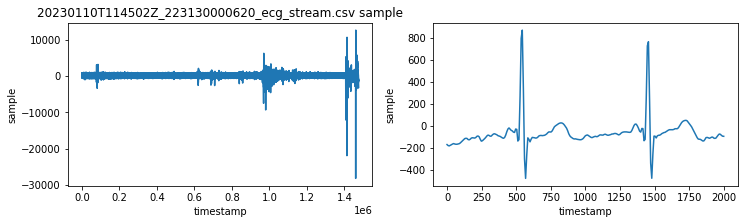

     average  rrData
0  66.500000     936
1  66.800000     888
2  67.200005     880
3  67.900000     864


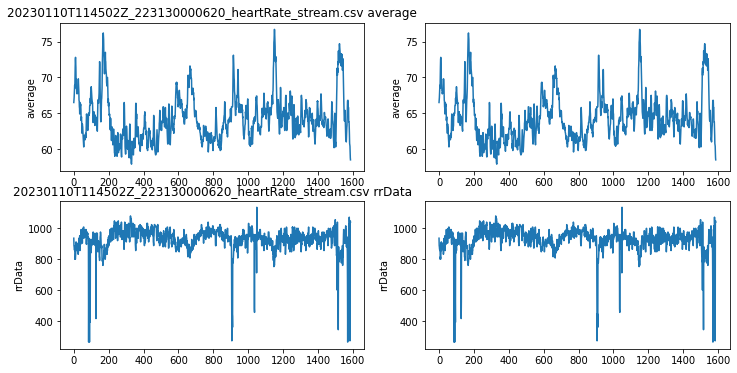

                  x         y         z
timestamp                              
0          6.398636 -3.340500  6.609212
9          6.398636 -3.311785  6.609212
18         6.391458 -3.290249  6.642713
28         6.384279 -3.316571  6.697750


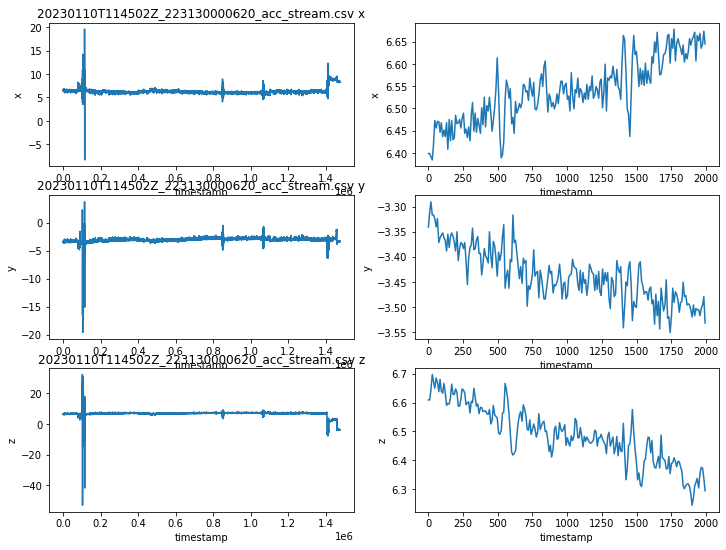

In [12]:
session_files = session_files.loc[session_files['FileType']=='csv',:].reset_index(drop=True)

for i in range(len(session_files)):
    sessF=session_files.loc[i,'File']
    data = pd.read_csv(data_loc + sessF)
    dets = sessF.split('_')
    if 'timestamp' in data.columns:
        data['timestamp'] = (data['timestamp']-data.loc[0,'timestamp'])
        data.set_index('timestamp',inplace = True)
    print(data.iloc[:4,:])
    feats = data.columns
    sub_data = data.loc[:2000,:]
    fig, ax = plt.subplots(len(feats),2,figsize=[12,3*len(feats)])
    if len(feats)>1:
        for i in range(len(feats)):
            feat =feats[i]
            a = ax[i,0]
            data[feat].plot(ax = a)
            a.set_ylabel(feat)
            a.set_title(sessF + ' ' + feat)
            a = ax[i,1]
            sub_data[feat].plot(ax = a)
            a.set_ylabel(feat)
        plt.savefig('./plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
        plt.show()
    else:
        feat = feats[0]
        a = ax[0]
        data[feat].plot(ax = a)
        a.set_ylabel(feat)
        a.set_title(sessF + ' ' + feat)
        a = ax[1]
        sub_data[feat].plot(ax = a)
        a.set_ylabel(feat)
        plt.savefig('./plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
        plt.show()            

In [66]:
# function for parsing json files of data output by the showcase app (probably)

def showcase_json(signal_tag,ml_data):
    if signal_tag == 'ecg':
        samples=16
        step = np.floor(ml_data['ecg.Timestamp'].diff().mean()/samples)
        times = ml_data['ecg.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(columns = [signal_tag],data = ml_data.loc[:,'ecg.Samples'].sum())
        sig_df['timestamps']=TimeStamps
        return sig_df
    if signal_tag == 'heartRate':
        sig_df = pd.DataFrame()
        sig_df['heartRate'] =ml_data['heartRate.average']
        sig_df['rrData'] =ml_data['heartRate.rrData'].sum()
        sig_df['timestamps']=ml_data.index
        return sig_df
    elif signal_tag == 'magn':
        samples=4
        step = np.floor(ml_data['magn.Timestamp'].diff().mean()/samples)
        times = ml_data['magn.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(data = ml_data.loc[:,'magn.ArrayMagn'].sum())
        sig_df.rename(columns={'x':'Magn_x','y':'Magn_y','z':'Magn_z'},inplace=True)
        sig_df['timestamps']=TimeStamps
        return sig_df
    elif signal_tag == 'gyro':
        samples=4
        step = np.floor(ml_data['gyroscope.Timestamp'].diff().mean()/samples)
        times = ml_data['gyroscope.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(data = ml_data.loc[:,'gyroscope.ArrayGyro'].sum())
        sig_df.rename(columns={'x':'Gyro_x','y':'Gyro_y','z':'Gyro_z'},inplace=True)
        sig_df['timestamps']=TimeStamps
        return sig_df
    elif signal_tag == 'acc':
        samples=4
        step = np.floor(ml_data['acc.Timestamp'].diff().mean()/samples)
        times = ml_data['acc.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig_df = pd.DataFrame(data = ml_data.loc[:,'acc.ArrayAcc'].sum())
        sig_df.rename(columns={'x':'Acc_x','y':'Acc_y','z':'Acc_z'},inplace=True)
        sig_df['timestamps']=TimeStamps
        return sig_df
    elif signal_tag == 'imu':
        samples=4
        step = np.floor(ml_data['imu.Timestamp'].diff().mean()/samples)
        times = ml_data['imu.Timestamp']
        TimeStamps = pd.DataFrame()
        for i in range(samples):
            TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
        TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

        sig1_df = pd.DataFrame(data = ml_data.loc[:,'imu.ArrayAcc'].sum())
        sig1_df.rename(columns={'x':'Acc_x','y':'Acc_y','z':'Acc_z'},inplace=True)
        sig2_df = pd.DataFrame(data = ml_data.loc[:,'imu.ArrayGyro'].sum())
        sig2_df.rename(columns={'x':'Gyro_x','y':'Gyro_y','z':'Gyro_z'},inplace=True)

        sig_df = pd.concat([sig1_df,sig2_df],axis=1)
        sig_df['timestamps']=TimeStamps
        return sig_df
    else:
        print('Not familiar signal')
        return

# Movesense from android showcase
Recording from app version 1.9.13

In [29]:
data_loc = './Movesense_Android_Showcase/'
# 'A10_07_2023-11-23_10-14-12_223130000599_HeartRateTestActivity.csv'
files = os.listdir(data_loc)

k = []
for f in files:
    if f.endswith('.csv'):
        file_type = 'csv'
        c = f.split('_')
        if len(c)>4:
            mobID =  c[0]
            sigType = c[-1][:-4]
            datet= dt.datetime.strptime(c[1],'%Y-%m-%d')
            dayt = dt.datetime.strptime(c[1]+c[2],'%Y-%m-%d%H-%M-%S')
            devID = int(c[-2])
            file_type = c[-1].split('.')[1]
            fl = {'Signal':sigType,'StartTime':dayt,'date':datet,'MovesenseID':devID,'MobileID':mobID
                  ,'FileType':file_type,'File':f}
            k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)

df_files

,Signal,StartTime,date,MovesenseID,MobileID,FileType,File
0,EcgActivityGraphView,2023-01-10 11:11:56,2023-01-10,223130000576,A10-09,csv,A10-09_2023-01-10_11-11-56_223130000576_EcgAct...
1,EcgActivityGraphView,2023-01-10 15:21:15,2023-01-10,223130000620,A10-07,csv,A10-07_2023-01-10_15-21-15_223130000620_EcgAct...
2,EcgActivityGraphView,2023-01-10 15:21:19,2023-01-10,223130000620,A10-07,csv,A10-07_2023-01-10_15-21-19_223130000620_EcgAct...
3,LinearAccelerationTestActivity,2023-01-11 14:09:07,2023-01-11,223130000555,A10-10,csv,A10-10_2023-01-11_14-09-07_223130000555_Linear...
4,HeartRateTestActivity,2023-11-23 10:14:12,2023-11-23,223130000599,A10-07,csv,A10-07_2023-11-23_10-14-12_223130000599_HeartR...
5,LinearAccelerationTestActivity,2023-11-23 10:14:15,2023-11-23,223130000599,A10-07,csv,A10-07_2023-11-23_10-14-15_223130000599_Linear...
6,LinearAccelerationTestActivity,2023-11-23 10:14:18,2023-11-23,223130000599,A10-07,csv,A10-07_2023-11-23_10-14-18_223130000599_Linear...
7,EcgActivityGraphView,2023-11-23 10:15:30,2023-11-23,223130000599,A10-07,csv,A10-07_2023-11-23_10-15-30_223130000599_EcgAct...
8,EcgActivityGraphView,2023-11-23 12:22:17,2023-11-23,223130000577,A10-07,csv,A10-07_2023-11-23_12-22-17_223130000577_EcgAct...


A10-09_2023-01-10_11-11-56_223130000576_EcgActivityGraphView.csv
   Timestamp  Count
0     115892      0
1     115900      0
2     115908     -1
3     115915     -2
Index(['Timestamp', 'Count'], dtype='object')
Timestamps: Timestamp


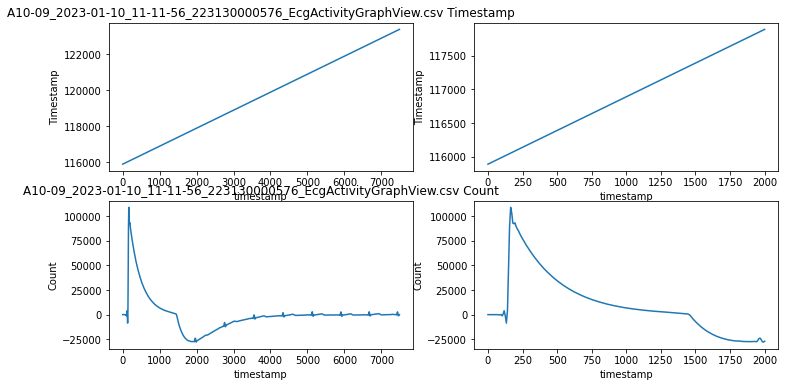

A10-07_2023-01-10_15-21-15_223130000620_EcgActivityGraphView.csv
   Timestamp  Count
0      28054      0
1      28062      0
2      28070     -1
3      28077     -2
Index(['Timestamp', 'Count'], dtype='object')
Timestamps: Timestamp


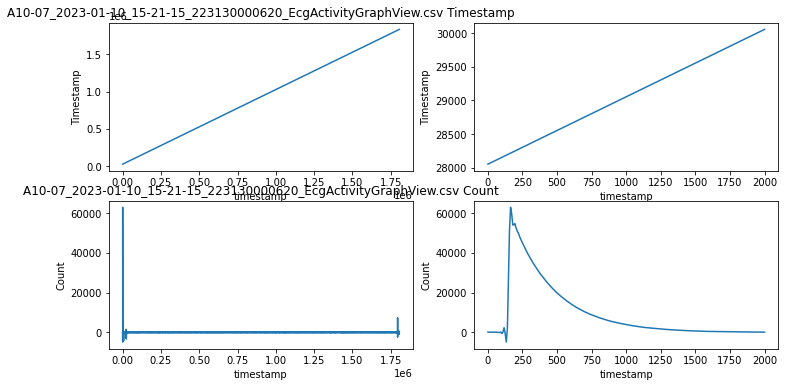

A10-07_2023-01-10_15-21-19_223130000620_EcgActivityGraphView.csv
   Timestamp  Count
0      28054      0
1      28062      0
2      28070     -1
3      28077     -2
Index(['Timestamp', 'Count'], dtype='object')
Timestamps: Timestamp


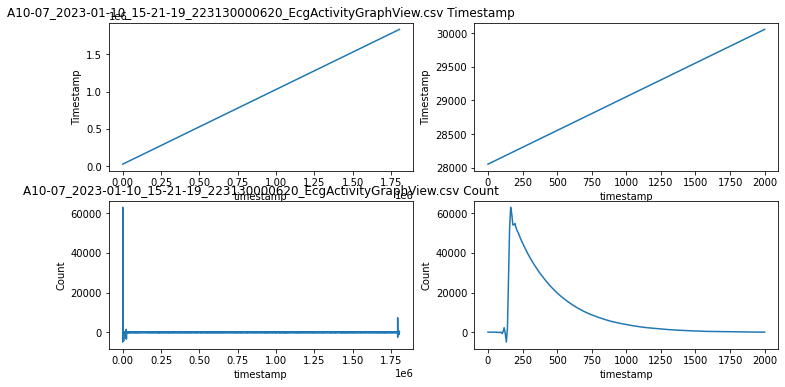

A10-10_2023-01-11_14-09-07_223130000555_LinearAccelerationTestActivity.csv
   Timestamp (ms)  X: (m/s^2)  Y: (m/s^2)  Z: (m/s^2)
0           30047    5.190217   -1.823396   -8.131102
1           30126    5.235683   -1.787502   -8.111959
2           30205    5.223718   -1.780324   -8.135887
3           30284    5.202182   -1.789895   -8.102386
Index(['Timestamp (ms)', 'X: (m/s^2)', 'Y: (m/s^2)', 'Z: (m/s^2)'], dtype='object')
Timestamps: Timestamp (ms)


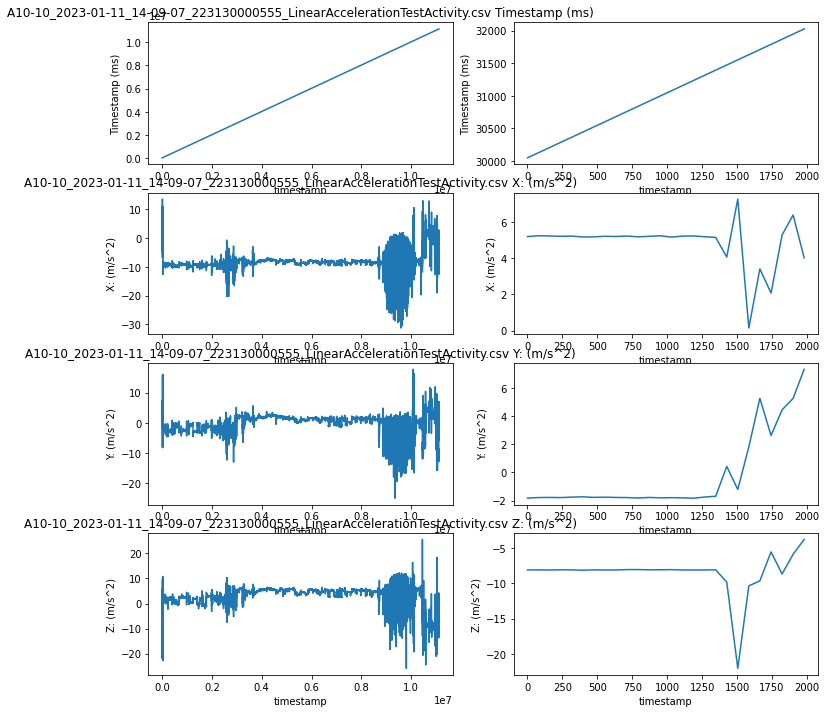

Empty file: A10-07_2023-11-23_10-14-12_223130000599_HeartRateTestActivity.csv
Empty file: A10-07_2023-11-23_10-14-15_223130000599_LinearAccelerationTestActivity.csv
Empty file: A10-07_2023-11-23_10-14-18_223130000599_LinearAccelerationTestActivity.csv
Empty file: A10-07_2023-11-23_10-15-30_223130000599_EcgActivityGraphView.csv
Empty file: A10-07_2023-11-23_12-22-17_223130000577_EcgActivityGraphView.csv


In [45]:
for i in range(len(df_files)):
    sessF =df_files.loc[i,'File']
    sigType = df_files.loc[i,'Signal']
    if os.stat(data_loc+sessF).st_size == 0:
        print('Empty file: ' + sessF)
    else:
        print(sessF)
        data = pd.read_csv(data_loc + sessF,index_col=False)
        print(data.iloc[:4,:])
        dets = sessF.split('_')
        
        # find a time stamp column despite variation is formating
        Cols = data.columns
        print(Cols)
        time_cols = [x for x in Cols if x.lower().startswith('time')]
        if len(time_cols)>0:
            time_col = time_cols[0]
            print('Timestamps: ' + time_col)
            data['timestamp'] = (data[time_col]-data.loc[0,time_col])
            data.set_index('timestamp',inplace = True)
        else:
            data['timestamp'] = data.index
            data.set_index('timestamp',inplace = True)
            
        feats = data.columns
        sub_data = data.loc[:2000,:]
        fig, ax = plt.subplots(len(feats),2,figsize=[12,3*len(feats)])
        for i in range(len(feats)):
            feat =feats[i]
            a = ax[i,0]
            data[feat].plot(ax = a)
            a.set_ylabel(feat)
            a.set_title(sessF + ' ' + feat)
            a = ax[i,1]
            sub_data[feat].plot(ax = a)
            a.set_ylabel(feat)
        plt.savefig('./plots/' + str(dev) + '_'+dets[2]+'_sample.png',dpi = 300)
        plt.show()


# Data logger files check 

In [ ]:
data_loc = './Movesense_Android_dataLogger/'
# 'MovesenseLog_2 2023-01-10 16_47_37.json'
files = os.listdir(data_loc)
k = []
for f in files:
    c = f.split(' ')
    if len(c)<4:
        mobID =  c[0].split('_')[0]
        SessN =  c[0].split('_')[1]
        file_type = c[-1].split('.')[1]
        
        sigType = 'NA'
        datet= dt.datetime.strptime(c[1],'%Y-%m-%d')
        dayt = dt.datetime.strptime(c[-2]+c[-1].split('.')[0],'%Y-%m-%d%H_%M_%S')
        devID = 'NA'
        file_type = c[-1].split('.')[1]
        fl = {'Signal':sigType,'StartTime':dayt,'date':datet,'MovesenseID':devID,'MobileID':mobID
              ,'FileType':file_type,'File':f}
        k.append(fl)
df_files=pd.DataFrame(data=k).sort_values('StartTime').reset_index(drop=True)
df_files


NA_MovesenseLog_3 2023-01-10 11_12_31.json
ECG
[['Timestamp'], ['RequiredSampleRate.Samples']]
   Timestamp                         RequiredSampleRate.Samples
0     113617  [0, -1, -2, -3, -5, -7, -6, -3, -15, -27, -19,...
1     113681  [69, 66, 31, 116, -28, 170, -137, 1953, 3812, ...
2     113745  [84470, 65958, 59892, 64489, 67077, 67302, 669...
3     113809  [68860, 68132, 67661, 67792, 68755, 70205, 714...
4     113873  [70661, 70378, 69889, 68910, 67351, 65362, 634...
5     113937  [43874, 42097, 40763, 39450, 38090, 36705, 352...
16
              ECG
timestamps       
113617          0
114017      22503


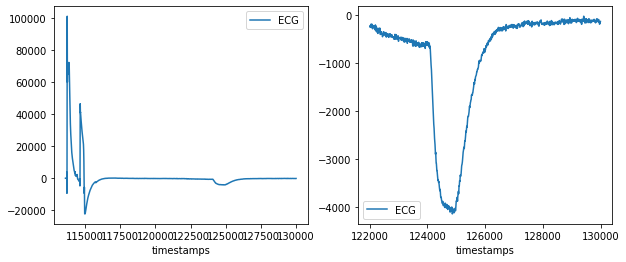

NA_MovesenseLog_2 2023-01-10 16_47_37.json
Acc
[['Timestamp'], ['ArrayAcc']]
                                            ArrayAcc  Timestamp
0  [{'x': 7.228975296020508, 'y': -3.163424491882...      25974
1  [{'x': 7.2194037437438965, 'y': -3.23760461807...      26050
2  [{'x': 7.159581184387207, 'y': -3.067708253860...      26125
3  [{'x': 7.075829029083252, 'y': -3.031814575195...      26201
4  [{'x': 7.176331520080566, 'y': -2.993528127670...      26277
5  [{'x': 7.224189758300781, 'y': -3.175389051437...      26352
8
                   x         y         z
timestamps                              
25974       7.228975 -3.163424 -5.702300
26917       7.207439 -3.012671 -5.630513


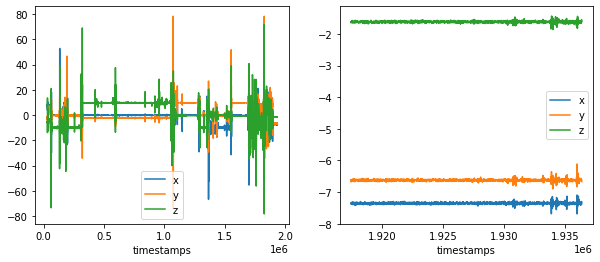

Hugh_MovesenseLog_2 2023-01-11 13_15_05.json
Acc
[['Timestamp'], ['ArrayAcc']]
                                            ArrayAcc  Timestamp
0  [{'x': -9.64341926574707, 'y': -14.38377094268...      70711
1  [{'x': -12.706341743469238, 'y': 4.81692409515...      70788
2  [{'x': -1.3759222030639648, 'y': -8.1813526153...      70865
3  [{'x': -3.302213191986084, 'y': -10.0191059112...      70942
4  [{'x': -4.52259635925293, 'y': -4.699671268463...      71018
5  [{'x': -7.549624919891357, 'y': -10.8207302093...      71095


In [ ]:
for i,f_dets in df_files.iterrows():
    f_dets = df_files.loc[i,:]
    file = f_dets['File']
    print(file)
    with open(data_loc + file,'r') as f:
        data = json.loads(f.read())
    rec_time = f_dets['StartTime']
    dk = list(data['Meas'].keys())
    print(dk[0])
    signal_tag = list(data['Meas'].keys())[0]
    ml_data = pd.json_normalize(data['Meas'][signal_tag])
    
    Cols = ml_data.columns
    time_cols = [x for x in Cols if x.lower().startswith('time')]
    sig_cols = [x for x in Cols if not x.lower().startswith('time')]
    print([time_cols,sig_cols])
    print(ml_data.loc[:5,:])
    
    signal_tag = list(data['Meas'].keys())[0]
    ml_data = pd.json_normalize(data['Meas'][signal_tag])
    sample_per_timestamp = len(ml_data.loc[0,sig_cols[0]])
    print(sample_per_timestamp )

    # restructure timestamps
    step = np.floor(ml_data['Timestamp'].diff().mean()/sample_per_timestamp )
    times = ml_data['Timestamp']
    TimeStamps = pd.DataFrame()
    for i in range(sample_per_timestamp ):
        TimeStamps = pd.concat([TimeStamps,times+i*step],axis=0)
    TimeStamps = pd.to_numeric(TimeStamps[0], downcast='integer').sort_values(0).reset_index(drop=True)

    # combine signal measurements (if single value samples. For vectors, try other)
    sig_df = pd.DataFrame(data = ml_data.loc[:,sig_cols[0]].sum())
    if len(sig_df.columns)<2:
        sig_df.rename(columns={0:signal_tag},inplace=True)
    sig_df['timestamps']=TimeStamps
    sig_df.set_index('timestamps',drop=True,inplace=True)
    print(sig_df.iloc[[0,100],:])
    
    fig, (ax1, ax2)=plt.subplots(1,2,figsize=[10,4])
    sig_df.plot(ax = ax1)
    sig_df.iloc[-2000:,:].plot(ax = ax2)
    plt.show()

Files are not generic in structure. Depends on the signal.